In [1]:
import pymysql
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from item_embedding import item_encode
from preprocess_user import make_user_fans_pipeline
from etl import load_user_info_features
from etl import load_fans_info_features

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Input, Embedding, Dot, Add,Flatten,Dense,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow as tf

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
def cdf(data):
    return np.sort(data), np.arange(1, len(data) + 1) / len(data)


def get_live_goods():
    '''Simply get live goods
    '''
    conn = pymysql.connect(host = '127.0.0.1', 
                       user = 'root', 
                       password = 'root123', 
                       db = 'delidou')

    live_goods = pd.read_sql_query('''
        select g.* from base_live_goods g
        inner join(
            select distinct u.id as uid from base_user_info u
            inner join(
                select id from base_user_fans
            ) f on u.id = f.id
        ) uf on g.id = uf.uid
    ''', conn)
    
    live_goods = live_goods.rename(columns = {'goods_id':'link_id'})
    
    return live_goods


def resample_goods(goods, neg_pos_ratio = 3):
    '''Sample to a resonable negtive to positive ratio'''
    
    positive = goods[goods.sales_count > 0]
    negative = goods[goods.sales_count == 0]
    neg_ids = np.random.choice(len(negative), size = len(positive) * neg_pos_ratio,replace = False)
    negative = negative.iloc[neg_ids,:]
    df = pd.concat([positive, negative],sort = False)
    df['sales_count_log1p'] = np.log1p(df['sales_count'])
    return df

In [3]:
# get goods
live_goods = get_live_goods()
live_goods = resample_goods(live_goods,1)

# get item encode
encoded_items,live_goods = item_encode(live_goods)

# parameters
n_users = live_goods['id'].nunique()
n_items = live_goods.link_id.nunique()
n_pref = live_goods.shape[0]

Building prefix dict from the default dictionary ...
I0822 18:58:50.437219 4633406912 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
I0822 18:58:50.439434 4633406912 __init__.py:131] Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
Loading model cost 0.606 seconds.
I0822 18:58:51.044929 4633406912 __init__.py:163] Loading model cost 0.606 seconds.
Prefix dict has been built succesfully.
I0822 18:58:51.046490 4633406912 __init__.py:164] Prefix dict has been built succesfully.


In [4]:
print('Number of users: {}'.format(n_users))
print('Number of items: {}'.format(n_items))
print('Number of records: {}'.format(n_pref))

Number of users: 2498
Number of items: 73754
Number of records: 213718


In [10]:
def preprocess_goods_live():
    '''
        Get goods data
        Encode goods to vectors
        
        Parameters:
        
        Returns:
            encoded_items: (N_items, item_embedding_dimension)
            goods: goods dataframe
    '''
    conn = pymysql.connect(host = '127.0.0.1', 
                       user = 'root', 
                       password = 'root123', 
                       db = 'delidou')
    
    # 
    goods = pd.read_sql_query('''
        select g.id as id, goods_id as link_id, g.name, g.tag  from base_live_goods g
        inner join(
            select distinct u.id as uid from base_user_info u
            inner join(
                select id from base_user_fans
            ) f on u.id = f.id
        ) uf on g.id = uf.uid
    ''', conn)
    
    
    encoded_items,goods = item_encode(goods)
    goods = goods.reset_index(drop = True)
    
    n_users = goods['id'].nunique()
    n_items = goods.link_id.nunique()
    n_pref = goods.shape[0]

    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Number of records: {}'.format(n_pref))
    
    return encoded_items, goods


def filter_goods_and_users(goods, user_n_item = 10, item_n_user = 10):
    '''
        Select top users and items
    '''
    
    item_count = goods.groupby('link_id')['id']\
        .agg(lambda x:len(set(x))).reset_index()\
        .sort_values(by = 'id',ascending = False)
    
    top_link_ids = item_count[item_count.id > item_n_user].link_id.values
    
    user_count = goods.groupby('id')['link_id']\
        .agg(lambda x:len(set(x))).reset_index()\
        .sort_values(by = 'link_id',ascending = False)
    
    top_user_ids = user_count[user_count.link_id > user_n_item].id.values
    
    goods = goods[(goods.id.isin(top_user_ids)) & (goods.link_id.isin(top_link_ids))]
    # goods = goods[(goods.id.isin(top_user_ids)) & (goods.link_id.isin(top_link_ids)) & (goods.id.isin(user_fans.id.values))]
    
    return goods,top_link_ids, top_user_ids



def load_user_features(n_regions = 30):
    
    '''Load user and fans data, process using predefined pipeline'''
    
    user = load_user_info_features()
    fans = load_fans_info_features()
    user_fans = user.merge(fans, on = 'id', how = 'inner')
    pipe = make_user_fans_pipeline(n_regions)
    user_features = pipe.fit_transform(user_fans)
    return user_features, user_fans



def userinfo_to_id(user_features, user_fans, user2id):
    result = []
    for user, f  in zip(user_fans.id.values, user_features):
        if user in user2id.keys():
            result.append([user2id[user],*f])

    user_features = pd.DataFrame(result)
    user_features.columns = ['user_id' if col == 0 else 'F_' + str(col) for col in user_features]
    user_features = user_features.iloc[:,1:]
    return user_features



def make_rating_table(goods):
    '''
        Make a 3 column rating table
    '''
    ratings = goods[['id','link_id']].copy()
    ratings['rating'] = 1
    ratings = ratings.rename(columns = {'id':'user_id','link_id':'item_id'})
    user2id = {user:i for i, user in enumerate(ratings.user_id.unique())}
    item2id = {item:i for i, item in enumerate(ratings.item_id.unique())}
    ratings['user_id'] = ratings['user_id'].replace(user2id)
    ratings['item_id'] = ratings['item_id'].replace(item2id)
    return ratings, user2id, item2id



def negative_sampling(ratings, n_negative = 50):
    '''
        Negative sampling
    '''
    all_items = set(ratings.item_id.unique())
    negative_samples = []
    for user_id in ratings.user_id.unique():
        user_items = set(ratings[ratings.user_id == user_id]['item_id'].tolist())
        space = list(all_items.difference(set(user_items)))
        neg_items = np.random.choice(space, size = n_negative)
        for neg_item in neg_items:
            negative_samples.append([user_id, neg_item,0])
    neg_ratings = pd.DataFrame(negative_samples,columns = ['user_id','item_id','rating'])
    dataset = pd.concat([ratings, neg_ratings])
    return dataset



def recommend_train_test_split(dataset, encoded_items, user_features, 
                               test_size = 0.1, shuffle = True):
    
    X_train, X_test, y_train,y_test =  train_test_split(dataset[['user_id','item_id']], 
                                                    dataset['rating'], 
                                                    test_size = 0.1, 
                                                    shuffle = True)

    item_encode_train = encoded_items[X_train.item_id.values]
    item_encode_test = encoded_items[X_test.item_id.values]
    
    user_feature_train = user_features.iloc[X_train.user_id.values,:]
    user_feature_test = user_features.iloc[X_test.user_id.values,:]
    
    
    print_info = '''
    ======================================
    Dataset Summary:
    ======================================
    X_train: {}
    X_test: {}
    item_encode_train: {}
    item_encode_test: {}
    user_feature_train: {}
    user_features_test: {}
    ======================================
    '''.format(X_train.shape, X_test.shape, 
               item_encode_train.shape, item_encode_test.shape, 
               user_feature_train.shape, user_feature_test.shape)
    
    print(print_info)
    
    return X_train, item_encode_train, user_feature_train,\
            X_test, item_encode_test, user_feature_test,y_train, y_test


def get_recommend_model(n_users, n_items, item_feature_dim, user_feature_dim, embed_hidden_dim = 10, reg = 0.):
    
    user_input = Input(1,)
    item_input = Input(1,)
    encoded_items_tensor = Input(item_feature_dim,)
    input_user_feature = Input(user_feature_dim,)

    user_embedding = Embedding(n_users,embed_hidden_dim, embeddings_regularizer=l2(reg))(user_input)
    item_embedding = Embedding(n_items,embed_hidden_dim, embeddings_regularizer=l2(reg))(item_input)

    user_bias = Embedding(n_users,1, embeddings_regularizer=l2(reg))(user_input)
    item_bias = Embedding(n_items,1, embeddings_regularizer=l2(reg))(item_input)

    rating_pred = Dot(axes = 2)([user_embedding, item_embedding])
    rating_pred = Add()([rating_pred, user_bias, item_bias])
    rating_pred = Flatten()(rating_pred)
    rating_pred = Concatenate()([rating_pred,encoded_items_tensor,input_user_feature])
    rating_pred = Dense(16, activation = 'relu')(rating_pred)
    rating_pred = Dense(1, activation = 'sigmoid')(rating_pred)

    model = Model([user_input, item_input,encoded_items_tensor,input_user_feature],rating_pred)
        
    model.compile(optimizer = Adam(lr = 0.001),loss = tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])
    return model
    
    
def evaluate_model(model, X_test, item_encode_test, user_feature_test,y_test):
    
    # predict
    preds = (model.predict(x = [X_test.user_id.values,
                                X_test.item_id.values,
                                item_encode_test, 
                                user_feature_test]) > 0.5).flatten()
    
    confuse = confusion_matrix(y_test, preds)
    fig, ax = plt.subplots(figsize = (6,4))
    sns.heatmap(confuse / confuse.sum(), annot = True)
    plt.title('Confusion Matrix')
    plt.show()
    
    auc = roc_auc_score(y_test, preds)
    acc = accuracy_score(y_test, preds)
    print('Accuracy Score: {}'.format(acc))
    print('Auc score: {}'.format(auc))

In [11]:
# items related pipelines
encoded_items, goods = preprocess_goods_live()
goods, top_link_ids, top_user_ids = filter_goods_and_users(goods)
ratings, user2id, item2id = make_rating_table(goods)
id2user = {v:k for k,v in user2id.items()}
id2item = {v:k for k,v in item2id.items()}

# user related pipelines
user_features, user_fans_df = load_user_features()
user_features = userinfo_to_id(user_features,user_fans_df,user2id)

# negative sampling ratings
dataset = negative_sampling(ratings)

# split and merge item and user data
X_train, item_encode_train, user_feature_train, \
    X_test, item_encode_test, user_feature_test,\
    y_train, y_test = recommend_train_test_split(dataset, 
                                                 encoded_items, 
                                                 user_features, 
                                                 test_size = 0.1,
                                                 shuffle = True)


# model structure based on data
model_params = dict(
    n_users = ratings.user_id.nunique(),
    n_items = ratings.item_id.nunique(),
    item_feature_dim = item_encode_train.shape[1],
    user_feature_dim = user_feature_train.shape[1],
    embed_hidden_dim = 10,
    reg = 0.
    )

# get the model
model = get_recommend_model(**model_params)

Number of users: 2515
Number of items: 91461
Number of records: 346134

    Dataset Summary:
    X_train: (36937, 2)
    X_test: (4105, 2)
    item_encode_train: (36937, 128)
    item_encode_test: (4105, 128)
    user_feature_train: (36937, 127)
    user_features_test: (4105, 127)
    


In [17]:
EPOCHS = 100

history = model.fit(x = [X_train.user_id.values,X_train.item_id.values,item_encode_train,user_feature_train.values],y = y_train.values,
                   epochs = EPOCHS,
                   batch_size = 1024,
                   validation_data = (
                   [X_test.user_id.values,X_test.item_id.values,item_encode_test,user_feature_test], y_test.values)
                   )

Train on 36937 samples, validate on 4105 samples
Epoch 1/100
36937/36937 [==============================] - 0s 4us/sample - loss: 0.0221 - accuracy: 0.9948 - val_loss: 0.5286 - val_accuracy: 0.9155
Epoch 2/100
36937/36937 [==============================] - 0s 4us/sample - loss: 0.0220 - accuracy: 0.9945 - val_loss: 0.5352 - val_accuracy: 0.9155
Epoch 3/100
36937/36937 [==============================] - 0s 4us/sample - loss: 0.0216 - accuracy: 0.9944 - val_loss: 0.5494 - val_accuracy: 0.9138
Epoch 4/100
36937/36937 [==============================] - 0s 4us/sample - loss: 0.0200 - accuracy: 0.9956 - val_loss: 0.5558 - val_accuracy: 0.9140
Epoch 5/100
36937/36937 [==============================] - 0s 4us/sample - loss: 0.0198 - accuracy: 0.9952 - val_loss: 0.5576 - val_accuracy: 0.9150
Epoch 6/100
36937/36937 [==============================] - 0s 4us/sample - loss: 0.0194 - accuracy: 0.9955 - val_loss: 0.5582 - val_accuracy: 0.9143
Epoch 7/100
36937/36937 [==============================] 

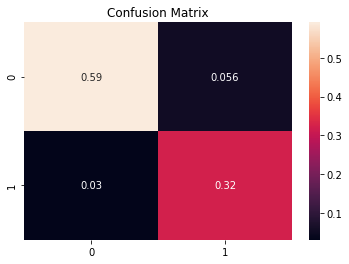

Accuracy Score: 0.9137637028014617
Auc score: 0.913873756344095


In [18]:
evaluate_model(model, X_test, item_encode_test, user_feature_test,y_test)

In [19]:
def generate_recommends():
    all_items = set(ratings.item_id.unique())
    user = np.random.choice(X_test.user_id.values)
    user = np.repeat([user],len(all_items))  

    recos = np.argsort(model.predict([user, np.array(list(all_items)),encoded_items[list(all_items),],user_features.iloc[user].values]).flatten())[::-1][:30]
    goods[goods['id'] == id2user[user[0]]]

    print('Recommendation List:\n')
    for i, reco in enumerate(recos):
        print('No {}, Item: {}'.format(i+1,goods[goods.link_id == id2item[reco]]['name'].iloc[0]))

    print('\n\nKnown positive:\n')
    for i, good in enumerate(goods[goods['id'] == id2user[user[0]]]['name'].unique().tolist()):
        print('No {}, Item: {}'.format(i, good))

In [41]:
generate_recommends()

Recommendation List:

No 1, Item: 实木衣架子衣挂家用挂衣架服装店专用防滑无痕木质衣服撑子挂钩
No 2, Item: 2月产蒙牛小真果粒饮品可爱萌mini小包儿童牛奶风味125ml*20盒
No 3, Item: 只投螺碗螺蛳粉柳州正宗包邮螺丝粉320g*5袋螺狮粉酸辣粉方便面条
No 4, Item: 为美兹蛋黄酥芝士流心奶黄酥6枚 夹心馅美食糕点早餐小吃零食品
No 5, Item: 水果坚果燕麦片营养早餐即食冲饮酸奶果粒代餐粥饱腹速食懒人食品
No 6, Item: 龙王豆浆粉商用速溶冲饮原味家用黑豆黄豆打豆浆早餐30g*16小包装
No 7, Item: 爱民螺蛳粉柳州正宗方便速食袋装香辣螺狮粉广西特产美食现货包邮
No 8, Item: 嗨吃家酸辣粉6桶装网红桶装整箱即食方面速食红薯粉丝米线旗舰店
No 9, Item: 贤合庄陈赫推荐网红自热火锅懒人自煮小火锅即食自助方便速食麻辣
No 10, Item: 苹果x钢化膜11promax全屏iPhoneX覆盖11pro/7/8/8Plus手机se2贴膜iPhone xs防窥iPhonexr/xsmax防窥膜xr/6s/6
No 11, Item: 靓涤垃圾袋家用手提式加厚实惠装一次性黑色背心拉圾桶塑料袋大号
No 12, Item: 章丘铁锅手工老式炒锅无涂层不粘锅家用炒菜锅电磁炉煤气灶专用锅
No 13, Item: 婴儿宝宝辅食锅煎蒸煮一体多功能麦饭石不粘锅儿童煮粥小奶锅炖锅
No 14, Item: 麦饭石不粘锅炒锅铁锅家用炒菜锅电磁炉煎炒两用平底锅煤气灶专用
No 15, Item: 颈椎按摩器家用电动智能护颈仪脖子按摩神器脉冲里疗肩颈部按摩仪
No 16, Item: 林家铺子【冰糖黄桃罐头200g*4罐】儿童水果罐头即食蒸制零食整箱
No 17, Item: 居家家杂物收纳盒3件套桌面化妆品储物收纳筐家用塑料厨房整理盒
No 18, Item: 卜珂麦丽素桶装怀旧黑巧克力夹心麦芽脆心球零食朱古力糖果送儿童
No 19, Item: 掌记咸蛋黄拌面116g*5袋装越南风味方便面泡面火鸡面带酱料包
No 20, Item: 原味乳酸菌饮品340mlx12瓶养胃风味酸牛奶动力儿童饮料整箱益生元
No 21, Item: 藤壶岛芝麻夹心海苔脆儿童即食海苔夹心脆海苔宝宝儿